# REINFORCE

---

In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [1]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

### 2. Define the Architecture of the Policy

In [3]:
env = gym.make('CartPole-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        """Returns an action and its log probability"""
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        # Creates a categorical distribution parameterized by logits (log probabilities)
        m = Categorical(probs)
        # Samples an action
        action = m.sample()
        # `m.log_prob(action)` returns the log of the probability density/mass 
        # function evaluated at value. For 0<=x<=1, -inf<=m.log_prob(x)<=0
        # If x over time becomes confident with a value closer to 1, m.log_prof(x)
        # will be tiny, so will be the product of it with the return R(tau)
        # for the arbitrary trajectory tau, which is how we get to the gradient. 
        return action.item(), m.log_prob(action)

observation space: Box(4,)
action space: Discrete(2)


### 3. Train the Agent with REINFORCE

In [4]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        # Define custom gradient on loss. 
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        # Sums over horizon H as shown in gradient ascend formula. 
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores
    
scores = reinforce()

Episode 100	Average Score: 34.47
Episode 200	Average Score: 66.26
Episode 300	Average Score: 87.82
Episode 400	Average Score: 72.83
Episode 500	Average Score: 172.00
Episode 600	Average Score: 160.65
Episode 700	Average Score: 167.15
Environment solved in 691 episodes!	Average Score: 196.69


### 4. Plot the Scores

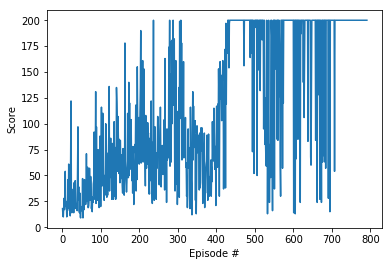

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In [6]:
env = gym.make('CartPole-v0')

state = env.reset()
for t in range(1000):
    action, _ = policy.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()

### Appendix: 

This code snippet illustrates how the custom loss is achieved. 
```python
import numpy as np
import torch 

x = [torch.from_numpy(np.random.rand(1)) for _ in range(10)]
R = 12.0
y = [-R*i for i in x]
loss = torch.cat(y).sum()
print(dir(loss))
```
Methods we can apply to tensors include `'__abs__', '__add__', '__and__', '__array__', '__array_wrap__', '__bool__', '__class__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__div__', '__doc__', '__eq__', '__float__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__idiv__', '__ilshift__', '__imul__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__long__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pow__', '__radd__', '__rdiv__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__rpow__', '__rshift__', '__rsub__', '__rtruediv__', '__setattr__', '__setitem__', '__setstate__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__weakref__', '__xor__', '_abs', '_addmv', '_addmv_', '_addr', '_addr_', '_argmax', '_argmin', '_backward_hooks', '_base', '_cast_Half', '_cast_double', '_cast_float', '_cast_int', '_cast_int16_t', '_cast_int64_t', '_cast_int8_t', '_cast_uint8_t', '_cdata', '_ceil', '_copy_ignoring_overlaps_', '_cos', '_dimI', '_dimV', '_dot', '_exp', '_fft_with_size', '_floor', '_ger', '_grad', '_grad_fn', '_indices', '_log', '_make_subclass', '_mm', '_mv', '_nnz', '_round', '_s_where', '_sin', '_sparse_mask', '_sqrt', '_standard_gamma', '_standard_gamma_grad', '_trunc', '_unique', '_values', '_version', 'abs', 'abs_', 'acos', 'acos_', 'add', 'add_', 'addbmm', 'addbmm_', 'addcdiv', 'addcdiv_', 'addcmul', 'addcmul_', 'addmm', 'addmm_', 'addmv', 'addmv_', 'addr', 'addr_', 'all', 'allclose', 'any', 'apply_', 'argmax', 'argmin', 'as_strided', 'as_strided_', 'asin', 'asin_', 'atan', 'atan2', 'atan2_', 'atan_', 'backward', 'baddbmm', 'baddbmm_', 'bernoulli', 'bernoulli_', 'bmm', 'btrifact', 'btrifact_with_info', 'btrisolve', 'byte', 'cauchy_', 'ceil', 'ceil_', 'char', 'chunk', 'clamp', 'clamp_', 'clone', 'coalesce', 'contiguous', 'conv_tbc', 'copy_', 'cos', 'cos_', 'cosh', 'cosh_', 'cpu', 'cross', 'cuda', 'cumprod', 'cumsum', 'data', 'data_ptr', 'det', 'detach', 'detach_', 'device', 'diag', 'digamma', 'digamma_', 'dim', 'dist', 'div', 'div_', 'dot', 'double', 'dtype', 'eig', 'element_size', 'eq', 'eq_', 'equal', 'erf', 'erf_', 'erfinv', 'erfinv_', 'exp', 'exp_', 'expand', 'expand_as', 'expm1', 'expm1_', 'exponential_', 'fft', 'fill_', 'float', 'floor', 'floor_', 'fmod', 'fmod_', 'frac', 'frac_', 'gather', 'ge', 'ge_', 'gels', 'geometric_', 'geqrf', 'ger', 'gesv', 'get_device', 'grad', 'grad_fn', 'gt', 'gt_', 'half', 'histc', 'ifft', 'index', 'index_add', 'index_add_', 'index_copy', 'index_copy_', 'index_fill', 'index_fill_', 'index_put_', 'index_select', 'int', 'inverse', 'irfft', 'is_coalesced', 'is_contiguous', 'is_cuda', 'is_distributed', 'is_floating_point', 'is_leaf', 'is_nonzero', 'is_pinned', 'is_same_size', 'is_set_to', 'is_shared', 'is_signed', 'is_sparse', 'isclose', 'item', 'kthvalue', 'layout', 'le', 'le_', 'lerp', 'lerp_', 'lgamma', 'lgamma_', 'log', 'log10', 'log10_', 'log1p', 'log1p_', 'log2', 'log2_', 'log_', 'log_normal_', 'logdet', 'long', 'lt', 'lt_', 'map2_', 'map_', 'masked_copy', 'masked_copy_', 'masked_fill', 'masked_fill_', 'masked_scatter', 'masked_scatter_', 'masked_select', 'matmul', 'max', 'mean', 'median', 'min', 'mm', 'mode', 'mul', 'mul_', 'multinomial', 'mv', 'name', 'narrow', 'ndimension', 'ne', 'ne_', 'neg', 'neg_', 'nelement', 'new', 'new_empty', 'new_full', 'new_ones', 'new_tensor', 'new_zeros', 'nonzero', 'norm', 'normal_', 'numel', 'numpy', 'orgqr', 'ormqr', 'output_nr', 'permute', 'pin_memory', 'polygamma', 'polygamma_', 'potrf', 'potri', 'potrs', 'pow', 'pow_', 'prod', 'pstrf', 'put_', 'qr', 'random_', 'reciprocal', 'reciprocal_', 'record_stream', 'register_hook', 'reinforce', 'relu', 'relu_', 'remainder', 'remainder_', 'renorm', 'renorm_', 'repeat', 'requires_grad', 'requires_grad_', 'reshape', 'resize', 'resize_', 'resize_as', 'resize_as_', 'retain_grad', 'rfft', 'round', 'round_', 'rsqrt', 'rsqrt_', 'scatter', 'scatter_', 'scatter_add', 'scatter_add_', 'select', 'set_', 'shape', 'share_memory_', 'short', 'sigmoid', 'sigmoid_', 'sign', 'sign_', 'sin', 'sin_', 'sinh', 'sinh_', 'size', 'slice', 'slogdet', 'smm', 'sort', 'split', 'split_with_sizes', 'sqrt', 'sqrt_', 'squeeze', 'squeeze_', 'sspaddmm', 'std', 'stft', 'storage', 'storage_offset', 'storage_type', 'stride', 'sub', 'sub_', 'sum', 'svd', 'symeig', 't', 't_', 'take', 'tan', 'tan_', 'tanh', 'tanh_', 'to', 'to_dense', 'tolist', 'topk', 'trace', 'transpose', 'transpose_', 'tril', 'tril_', 'triu', 'triu_', 'trtrs', 'trunc', 'trunc_', 'type', 'type_as', 'unfold', 'uniform_', 'unique', 'unsqueeze', 'unsqueeze_', 'var', 'view', 'view_as', 'where', 'zero_'`. 